~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/derm-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fderm-foundation%2Fmaster%2Fnotebooks%2Ftrain_data_efficient_classifier.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/derm-foundation/blob/master/notebooks/train_data_efficient_classifier.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/derm-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

# Classifying Skin Conditions with the Derm Foundation and SCIN Dataset

In this notebook we will train a model to classify skin conditions from images in the [SCIN Dataset](https://github.com/google-research-datasets/scin) based on embeddings generated by the [Derm Foundation model](https://developers.google.com/health-ai-developer-foundations/derm-foundation).


The SCIN (Skin Condition Image Network) open access dataset contains 5,000+ volunteer contributions (10,000+ images) of common dermatology conditions. The SCIN dataset was collected from Google Search users in the United States through a voluntary, consented image donation application. 3 Dermatologists labeled each image with up to 3 conditions, and a confidence rating from 1-5 for each condition. For example:

Dermatologist labels:
- Dermatologist 1's label: Eczema with confidence 3, Acute and chronic dermatitis with confidence 2, Psoriasis vulgaris with confidence 1

- Dermatologist 2's label: Eczematous dermatitis with confidence 3

- Dermatologist 3's label: Eczematous dermatitis with confidence 4, Post-inflammatory hyperpigmentation with confidence 3

The labels would be as follows:

- dermatologist_skin_condition_label_name: Eczema, Acute and chronic dermatitis, Psoriasis vulgaris, Eczematous dermatitis, Eczematous dermatitis, Post-inflammatory hyperpigmentation

- dermatologist_skin_condition_confidence: [3, 2, 1, 3, 4, 3]  

The Derm Foundation model is used to generate rich embeddings for dermatological images allowing us to train a machine learning model with less data and compute compared to training from scratch. Visit the [Derm Foundation Page](https://developers.google.com/health-ai-developer-foundations/derm-foundation) on the HAI-DEF site to learn more about the model and see this notebook to learn more about the [SCIN dataset](https://github.com/google-research-datasets/scin/blob/main/scin_demo.ipynb).

We will frame this as a multi-label classification problem, where the model takes in a 6144 dimensional embedding and the label is which of the following skin conditions the patient had `['Eczema', 'Allergic Contact Dermatitis', 'Insect Bite', 'Urticaria', 'Psoriasis', 'Folliculitis', 'Irritant Contact Dermatitis', 'Tinea', 'Herpes Zoster', 'Drug Rash']`. Using our example above our label will be `[ 0 1 0 1 0 0 0 0 0 0 ]`, since at least one doctor labeled the conditions Eczema and Psoriasis.

In [1]:
import collections
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# Authenticate to Access Data
The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [3]:
from google.colab import auth
from google.cloud import storage

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder
from huggingface_hub import notebook_login

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Load SCIN Dataset and Pre-computed Embeddings

Since it takes ~hours to generate the embeddings we will dowload some pre-computed ones from HuggingFace. If you would like to generate your own see HuggingFace model card.

In [4]:
# Load SCIN Dataset

SCIN_GCP_PROJECT = 'dx-scin-public'
SCIN_GCS_BUCKET_NAME = 'dx-scin-public-data'
SCIN_GCS_CASES_CSV = 'dataset/scin_cases.csv'
SCIN_GCS_LABELS_CSV = 'dataset/scin_labels.csv'
SCIN_GCS_IMAGES_DIR = 'dataset/images/'


def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)

scin_no_label_df = initialize_df_with_metadata(scin_bucket, SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, scin_bucket, SCIN_GCS_LABELS_CSV)
scin_df.set_index('case_id', inplace=True)
print(f'Loaded {len(scin_df)} rows.')

# scin_df is the main data frame we will be working with.
scin_df.head(5)

Loaded 5033 rows.


,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
case_id,,,,,,,,,,,,,,,,,,,,,
-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('case_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('age_group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('sex_at_birth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('fitzpatrick_skin_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('case_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='case_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_group')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sex_at_birth')):
  _plot_series(series, series_name, i)
  fig.legend(title='sex_at_birth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fitzpatrick_skin_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='fitzpatrick_skin_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['age_group'].value_counts()
    for x_label, grp in _df_8.groupby('case_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('case_id')
_ = plt.ylabel('age_group')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sex_at_birth'].value_counts()
    for x_label, grp in _df_9.groupby('age_group')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('age_group')
_ = plt.ylabel('sex_at_birth')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['fitzpatrick_skin_type'].value_counts()
    for x_label, grp in _df_10.groupby('sex_at_birth')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('sex_at_birth')
_ = plt.ylabel('fitzpatrick_skin_type')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race_ethnicity_hispanic_latino_or_spanish_origin'].value_counts()
    for x_label, grp in _df_11.groupby('fitzpatrick_skin_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('fitzpatrick_skin_type')
_ = plt.ylabel('race_ethnicity_hispanic_latino_or_spanish_origin')

In [11]:
scin_df.columns

Index(['source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearance',
      

In [5]:
# Load Precomputed Embeddings for SCIN Dataset
SCIN_HF_MODEL_NAME = 'google/derm-foundation'
SCIN_HF_EMBEDDING_FILE = 'scin_dataset_precomputed_embeddings.npz'

!pip install huggingface_hub 2>&1 1>/dev/null
from huggingface_hub import hf_hub_download
import numpy as np

def load_embeddings_from_file(repo_id, object_name):
  file_path = hf_hub_download(repo_id=SCIN_HF_MODEL_NAME, filename=object_name, local_dir='/content/')

  # Parse NPZ file
  embeddings = dict()
  with open(file_path, 'rb') as f:
      x = np.load(f, allow_pickle=True)  # Load the numpy file

      # Iterate over items if it's a .npz file (which contains multiple arrays)
      for k, v in x.items():
        embeddings[k] = v

  return embeddings

# embeddings - a dict mapping image path -> embedding
embeddings = load_embeddings_from_file(SCIN_HF_MODEL_NAME, SCIN_HF_EMBEDDING_FILE)

print(f'Loaded {len(embeddings)} embeddings.')
for k, v in embeddings.items():
  print(f'Embeddings map {k} to {v.shape}')
  break

scin_dataset_precomputed_embeddings.npz:   0%|          | 0.00/514M [00:00<?, ?B/s]

Loaded 10379 embeddings.
Embeddings map dataset/images/-3205742176803893704.png to (6144,)


# Explore SCIN Dataset

Dropdown(description='Case ID', options=('-1000600354148496558', '-1002039107727665188', '-1003358831658393077…

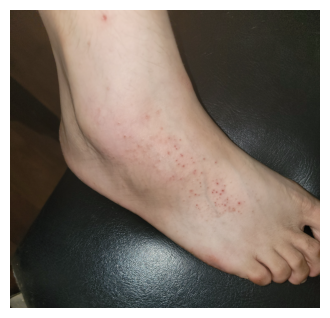

Skin Conditions ['Inflicted skin lesions', 'Eczema', 'Irritant Contact Dermatitis']
Confidence [4, 4, 3]


In [6]:
import ipywidgets as widgets
from IPython.display import display
from google.colab import output as colab_output

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  f, axarr = plt.subplots(1, 1, figsize = (4, 4))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id):
  # Each volunteer contributor submitted up to 3 images
  image_paths = [df.loc[case_id, 'image_1_path'], df.loc[case_id, 'image_2_path'], df.loc[case_id, 'image_3_path']]
  for path in image_paths:
    if isinstance(path, str):
      scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)
      display_image(scin_bucket, path)

  conditions = df.loc[case_id, 'dermatologist_skin_condition_on_label_name']
  confidence = df.loc[case_id, 'dermatologist_skin_condition_confidence']
  print(f'Skin Conditions {conditions}')
  print(f'Confidence {confidence}')


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        colab_output.clear()
        display(case_id_dropdown)
        display_images_for_case(scin_df,case_id=change['new'])

case_id_dropdown = widgets.Dropdown(options=scin_df.index, description="Case ID")
display(case_id_dropdown)
case_id_dropdown.observe(on_change)
display_images_for_case(scin_df, case_id_dropdown.value)

In [18]:
len(scin_df['dermatologist_skin_condition_on_label_name'])
len(scin_df.columns)

72

In [19]:
def print_condition_distribution(df, top_n_conditions=50):

  # Any condition that shows up in a label
  condition_ctr = collections.Counter()
  print(f'Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:')
  for entry in df['dermatologist_skin_condition_on_label_name'].dropna():
    condition_ctr.update(eval(entry))
  for condition, cnt in condition_ctr.most_common()[:50]:
    print(f'  {condition}: {cnt}')

print_condition_distribution(scin_df)

Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

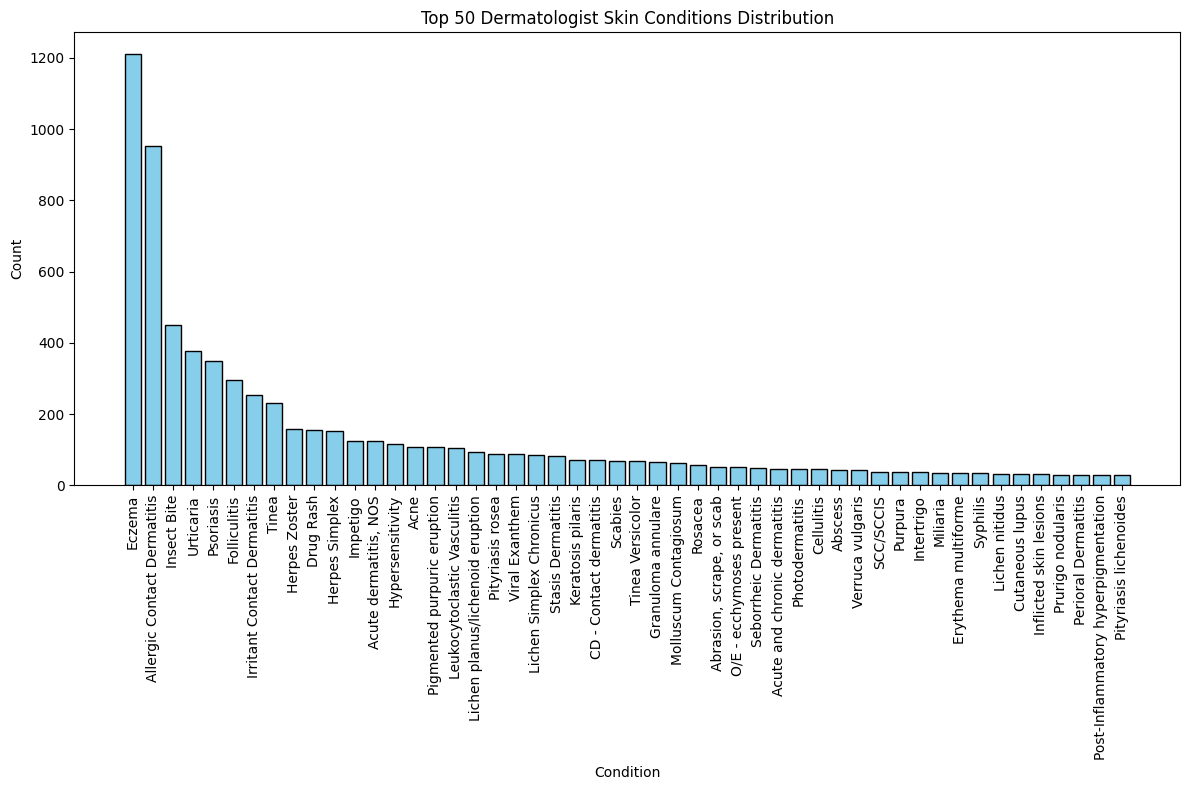

In [20]:
import collections
import matplotlib.pyplot as plt

def plot_condition_distribution(df, top_n_conditions=50):
    condition_ctr = collections.Counter()
    print(f'Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:')

    # Aggregate counts of all conditions
    for entry in df['dermatologist_skin_condition_on_label_name'].dropna():
        condition_ctr.update(eval(entry))

    # Print top N conditions
    for condition, cnt in condition_ctr.most_common(top_n_conditions):
        print(f'  {condition}: {cnt}')

    # Prepare data for plotting
    top_conditions = condition_ctr.most_common(top_n_conditions)
    conditions, counts = zip(*top_conditions)

    # Plot bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(conditions)), counts, color='skyblue', edgecolor='black')
    plt.xticks(range(len(conditions)), conditions, rotation=90)
    plt.xlabel('Condition')
    plt.ylabel('Count')
    plt.title(f'Top {top_n_conditions} Dermatologist Skin Conditions Distribution')
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
plot_condition_distribution(scin_df)


# Clean and Prepare the Data

We will try and predict the 10 most common conditions:

`['Eczema', 'Allergic Contact Dermatitis', 'Insect Bite', 'Urticaria', 'Psoriasis', 'Folliculitis', 'Irritant Contact Dermatitis', 'Tinea', 'Herpes Zoster', 'Drug Rash']`


Our training data X will be a list of embeddings of size`(6144,)` and our labels y will be a list of binary labels of size `(10,)`. For example, `[0, 1, 0, 0, 1, 0, 1, 0, 0, 1]`.

We filter examples if the Dermatologists labeled it with insufficient image quality. We also filter labels that are below our minimum confidence. For example, if we set minimum confidence to 3 and the Dermatologist labeled Eczema with confidence 2, we included the example, but Eczma will be set to 0 not 1 in our label.

Finally, the skin condition labels are imbalanced. For example we have 156 examples with drug rash and 6295 examples without. Typically, you want to split your data such that there is an even distribution of positive labels for each condition in the train and test sets. We will print out the distributions, but don't explicitly create even distributions in this notebook.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

def prepare_data():
  CONDITIONS_TO_PREDICT = ['Eczema', 'Allergic Contact Dermatitis', 'Insect Bite', 'Urticaria', 'Psoriasis', 'Folliculitis', 'Irritant Contact Dermatitis', 'Tinea', 'Herpes Zoster', 'Drug Rash']
  MINIMUM_CONFIDENCE = 3

  X = []
  y = []
  poor_image_quality_counter = 0
  missing_embedding_counter = 0
  not_in_condition_to_predict_counter = 0
  condition_confidence_low_counter = 0

  for row in scin_df.itertuples():
    if row.dermatologist_gradable_for_skin_condition_1 != 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
      poor_image_quality_counter += 1
      continue

    # eval converts from string to dict
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidence = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidence):
      if label not in CONDITIONS_TO_PREDICT:
        not_in_condition_to_predict_counter += 1
        continue
      if confidence < MINIMUM_CONFIDENCE:
        condition_confidence_low_counter += 1
        continue
      row_labels.append(label)

    for image_path in [row.image_1_path, row.image_2_path, row.image_3_path]:
      if pd.isna(image_path):
        continue
      if image_path not in embeddings:
        missing_embedding_counter += 1
        continue

      X.append(embeddings[image_path])
      y.append(row_labels)

  print(f'Poor image quality: {poor_image_quality_counter}')
  print(f'Missing embedding: {missing_embedding_counter}')
  print(f'Condition not in "CONDITIONS_TO_PREDICT": {not_in_condition_to_predict_counter}')
  print(f'Exluded label confidence too low: {condition_confidence_low_counter}')
  return X, y


X, y = prepare_data()
# Convert y from [['Eczma'], ['Urticaria', 'Insect Bite']] to
# [[0 0 1 0 0 0 0 0 0 0], [0 0 0 1 1 0 0 0 0 0]]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

Poor image quality: 1984
Missing embedding: 1
Condition not in "CONDITIONS_TO_PREDICT": 3713
Exluded label confidence too low: 2639


In [22]:
from sklearn.model_selection import train_test_split

print(f'Length of X: {len(X)}')
print(f'Length of Y: {len(y)}')
print(f'Sample from X: {X[0].shape}')
print(f'Sample from y: {y[0]}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def print_label_distribution(y):
  label_counts = {}

  # Iterate through the labels and count occurrences
  for label_vector in y:
    for index, value in enumerate(label_vector):
      if value == 1:
        label_counts[mlb.classes_[index]] = label_counts.get(mlb.classes_[index], 0) + 1

  # Print the distribution
  for condition in mlb.classes_:
    print(f"{condition}: {round(label_counts[condition]/len(y), 4)}")

print("\nPercentage of positive labels by condition in train:")
print_label_distribution(y_train)
print("\nPercentage of positive labels by condition in test:")
print_label_distribution(y_test)

Length of X: 6451
Length of Y: 6451
Sample from X: (6144,)
Sample from y: [0 0 1 0 0 0 1 0 0 0]

Percentage of positive labels by condition in train:
Allergic Contact Dermatitis: 0.0936
Drug Rash: 0.0122
Eczema: 0.164
Folliculitis: 0.0397
Herpes Zoster: 0.0186
Insect Bite: 0.0581
Irritant Contact Dermatitis: 0.0271
Psoriasis: 0.0293
Tinea: 0.0275
Urticaria: 0.0678

Percentage of positive labels by condition in test:
Allergic Contact Dermatitis: 0.1007
Drug Rash: 0.0101
Eczema: 0.151
Folliculitis: 0.0395
Herpes Zoster: 0.0147
Insect Bite: 0.0682
Irritant Contact Dermatitis: 0.0232
Psoriasis: 0.0325
Tinea: 0.0225
Urticaria: 0.0457


# Train a Logistic Regression Classifier

Using the MultiOutputClassifier wrapper sklearn will train 10 different logistic regression models. One for each of our labels. Let's see how they do!

In [42]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

lr_classifier = MultiOutputClassifier(LogisticRegression(C= 0.051, max_iter=472)).fit(X_train, y_train)
y_pred = lr_classifier.predict_proba(X_test)

# The predict_proba are returned in a funky format so reconfigure to (1291,10)
cols = []
for i in range(len(mlb.classes_)):
  cols.append(y_pred[i][:,1])
y_pred = np.column_stack(cols)
y_pred.shape

(1291, 10)

# Evaluate Results

We will use the [hamming loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html) instead of accuracy to get a general sense of how our model is performing. For accuracy the predictions must exactly match the labels, so if even one of the 10 predictions are wrong the whole example is marked as incorrect. The hamming loss is the fraction of labels that are incorrectly predicted, which is more forgiving.

In [46]:
from sklearn.metrics import multilabel_confusion_matrix, hamming_loss, ConfusionMatrixDisplay, RocCurveDisplay

def plot_confusion_matrix(y_test, y_pred, classes):
  y_bool = (y_pred >= 0.5).astype(int)
  cnf_matrix = multilabel_confusion_matrix(y_test, y_bool)
  _, axes = plt.subplots(2, 5, figsize=(14, 6), tight_layout=True)
  for cf, cl, ax in zip(cnf_matrix, classes, axes.flatten()):
    ax.set_title(cl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf)
    disp.plot(ax=ax)
  plt.show()

def print_hamming_loss(y_test, y_pred):
  y_bool = (y_pred >= 0.5).astype(int)
  print(f'\n### Hamming Loss: {hamming_loss(y_test, y_bool)} ###')

def plot_roc_curve(y_test, y_pred, classes):
  _, axes = plt.subplots(2, 5, figsize=(14, 6), tight_layout=True)
  for i, (cl, ax) in enumerate(zip(classes, axes.flatten())):
    ax.set_title(cl)
    RocCurveDisplay.from_predictions(y_test[:, i], y_pred[:, i], ax=ax)
  plt.show()

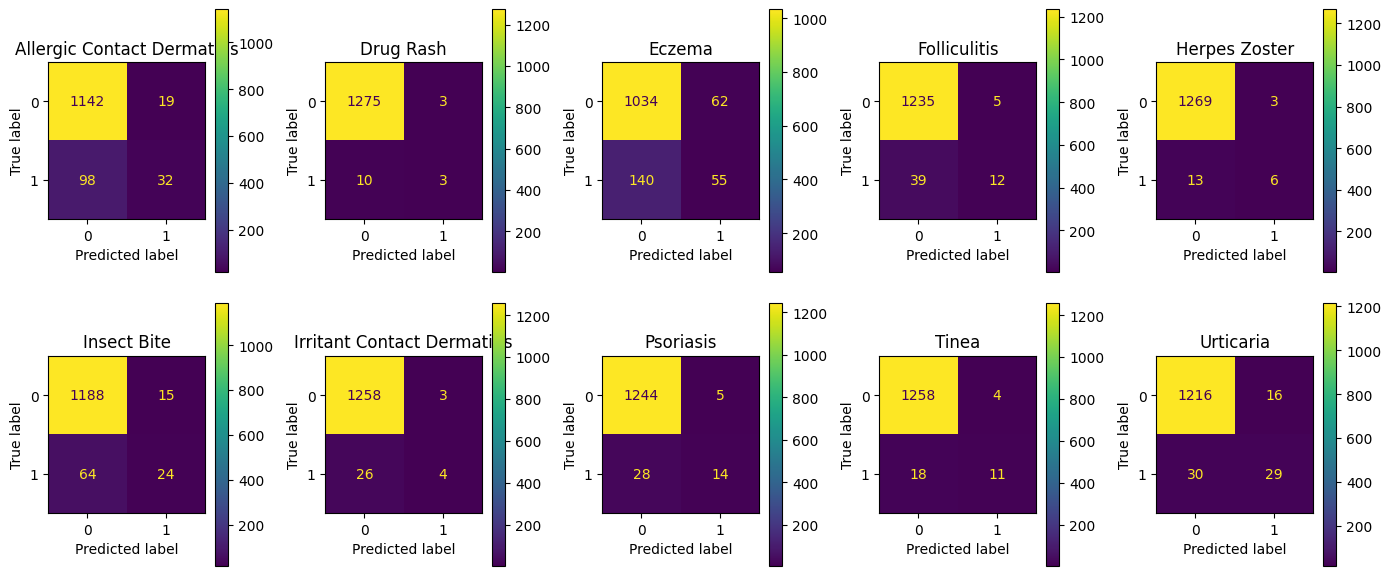

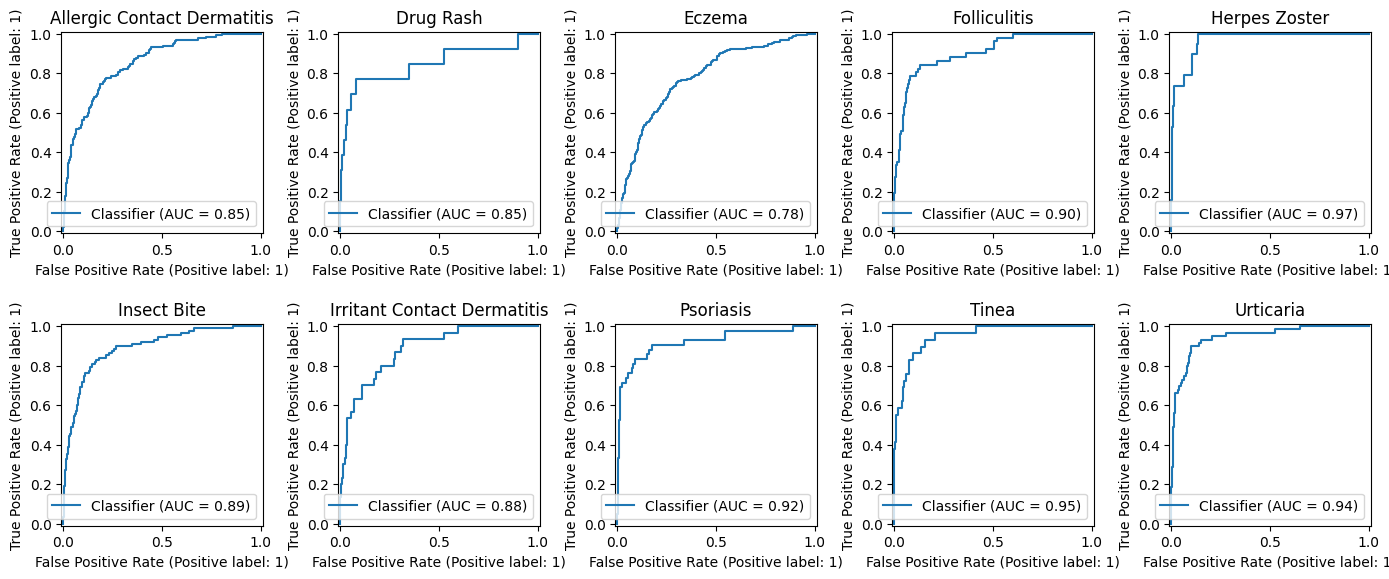


### Hamming Loss: 0.04655305964368706 ###


In [47]:
plot_confusion_matrix(y_test, y_pred, mlb.classes_)
plot_roc_curve(y_test, y_pred, mlb.classes_)
print_hamming_loss(y_test, y_pred)

In [49]:
import joblib

joblib_file = 'derm_found_logistic_v1.pkl'
joblib.dump(lr_classifier, joblib_file)

['derm_found_logistic_v1.pkl']

In [50]:
model = joblib.load('derm_found_logistic_v1.pkl')

In [51]:
score = model.score(X_test,y_test)

In [53]:
score*100

np.float64(59.876065065840436)

In [58]:
predictions = model.predict(X_test)
print(f'Shapes: {predictions.shape}')
print(f'Sample Prediction: {predictions[100]}')

Shapes: (1291, 10)
Sample Prediction: [0 0 1 0 0 0 0 0 0 0]


In [ ]:
!pip install optuna

In [35]:
import mlflow
import mlflow.sklearn
import optuna
import numpy as np

mlflow.set_tracking_uri("file:/content/mlruns")  # Local file logging
mlflow.set_experiment("MultiOutput_LogisticRegression_Optuna")


2025/06/26 07:00:30 INFO mlflow.tracking.fluent: Experiment with name 'MultiOutput_LogisticRegression_Optuna' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/812493473144595450', creation_time=1750921230963, experiment_id='812493473144595450', last_update_time=1750921230963, lifecycle_stage='active', name='MultiOutput_LogisticRegression_Optuna', tags={}>

In [36]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss

def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_loguniform('C', 1e-3, 10)
    max_iter = trial.suggest_int('max_iter', 100, 500)

    # Model
    base_lr = LogisticRegression(C=C, max_iter=max_iter)
    model = MultiOutputClassifier(base_lr)

    with mlflow.start_run(nested=True):
        # Fit model
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)

        # Reformat output
        cols = [y_pred[i][:, 1] for i in range(len(y_pred))]
        y_pred_proba = np.column_stack(cols)

        # Threshold to binary
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)

        # Metric
        h_loss = hamming_loss(y_test, y_pred_binary)

        # Log params and metric
        mlflow.log_params({'C': C, 'max_iter': max_iter})
        mlflow.log_metric("hamming_loss", h_loss)

        # Log model
        mlflow.sklearn.log_model(model, "model")

    return h_loss


In [37]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2025-06-26 07:01:16,431] A new study created in memory with name: no-name-4cabb447-603c-432e-b470-33c5931da455
/tmp/ipython-input-36-1971632523.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 10)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/06/26 07:02:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Pleas

In [38]:
print("Best trial:")
print(study.best_trial.params)
print(f"Hamming Loss: {study.best_trial.value}")

Best trial:
{'C': 0.05109550189175223, 'max_iter': 472}
Hamming Loss: 0.04632068164213788


In [ ]:
!zip -r mlruns.zip mlruns
from google.colab import files
files.download("mlruns.zip")

# Train a Neural Net

Let's see if a simple neural network can do better! Since this is a multi-label classification problem we will use a sigmoid activation function instead of softmax.

# xgboost

In [69]:
len(X)*0.80

5160.8

In [70]:
len(X_train)

5160

In [ ]:
import multiprocessing

# from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

if __name__ == "__main__":
    print("Parallel Parameter optimization")
    # X, y = fetch_california_housing(return_X_y=True)
    # Make sure the number of threads is balanced.
    xgb_model = xgb.XGBRegressor(
        n_jobs=multiprocessing.cpu_count() // 2, tree_method="hist"
    )
    clf = GridSearchCV(
        xgb_model,
        {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=2,
    )
    clf.fit(X_train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)

Parallel Parameter optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
b

# Next steps

Explore the other [notebooks](https://github.com/google-health/derm-foundation/blob/master/notebooks) to learn what else you can do with the model.